In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

# 读取所有的 CSV 文件
csv_files = glob.glob('*.csv')  # 获取当前目录下所有的 CSV 文件
data_list = []
global_worm_id_offset = 0  # 全局 WormID 偏移量

for file in csv_files:
    # 读取数据
    df = pd.read_csv(file)
    
    # 获取当前文件中的 WormID 并进行重编号
    unique_worm_ids = df['WormID'].unique()
    worm_id_map = {old_id: new_id + global_worm_id_offset for new_id, old_id in enumerate(unique_worm_ids)}
    df['WormID'] = df['WormID'].map(worm_id_map)
    
    # 更新全局 WormID 偏移量
    global_worm_id_offset += len(unique_worm_ids)
    
    # 添加到数据列表
    data_list.append(df)

# 合并所有的数据框
data = pd.concat(data_list, ignore_index=True)

# 按照 WormID 和 Frame 排序
data = data.sort_values(by=['WormID', 'Frame'])

# 定义坐标列
coordinate_columns = ['Centroid_X', 'Centroid_Y', 'KeypointA_X', 'KeypointA_Y', 'KeypointB_X', 'KeypointB_Y']

# 归一化坐标数据
scaler = MinMaxScaler()
data[coordinate_columns] = scaler.fit_transform(data[coordinate_columns])

# 划分训练集和测试集
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

/home/spuser/.conda/envs/yanpan_DL/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:

# 定义 Dataset 类
class WormTrajectoryDataset(Dataset):
    def __init__(self, data, seq_length):
        self.seq_length = seq_length
        self.coordinate_columns = coordinate_columns
        self.grouped = data.groupby('WormID')
        self.data_sequences = []

        # 预处理每只线虫的轨迹
        for worm_id, worm_data in self.grouped:
            worm_data = worm_data.sort_values('Frame')
            coords = worm_data[self.coordinate_columns].values

            # 将轨迹分割成长度为 seq_length 的子序列
            if len(coords) >= seq_length + 1:
                for i in range(len(coords) - seq_length):
                    input_seq = coords[i:i+seq_length]
                    target_seq = coords[i+1:i+seq_length+1]
                    self.data_sequences.append((input_seq, target_seq))

    def __len__(self):
        return len(self.data_sequences)

    def __getitem__(self, idx):
        input_seq, target_seq = self.data_sequences[idx]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

# 定义序列长度
seq_length = 500

# 创建数据集和数据加载器
train_dataset = WormTrajectoryDataset(train_data, seq_length)
test_dataset = WormTrajectoryDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [5]:

# 定义模型
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TrajectoryPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, input_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

# 定义模型参数
input_size = len(coordinate_columns)
hidden_size = 64
num_layers = 2

model = TrajectoryPredictor(input_size, hidden_size, num_layers)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 检查是否有可用的 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

# 测试模型
model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print(f'Test Loss: {avg_loss:.6f}')


Epoch [1/10], Loss: 0.001897
Epoch [2/10], Loss: 0.000025
Epoch [3/10], Loss: 0.000018
Epoch [4/10], Loss: 0.000015
Epoch [5/10], Loss: 0.000013
Epoch [6/10], Loss: 0.000012
Epoch [7/10], Loss: 0.000012
Epoch [8/10], Loss: 0.000011
Epoch [9/10], Loss: 0.000011
Epoch [10/10], Loss: 0.000011
Test Loss: 0.000017


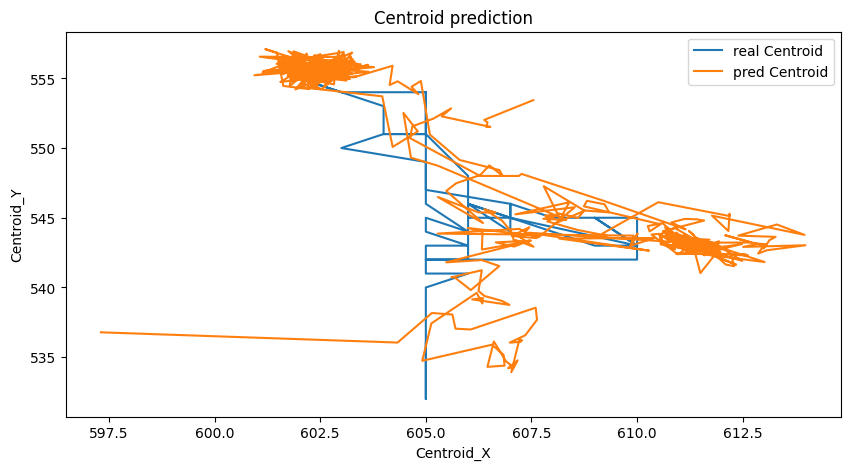

Worm 1 的3D轨迹图已保存至 1.png


In [7]:

# 预测与可视化
# 选取测试集中的一条轨迹
sample_input, sample_target = test_dataset[0]
sample_input = sample_input.unsqueeze(0).to(device)  # 添加批次维度并移动到设备

model.eval()
with torch.no_grad():
    predicted = model(sample_input)

# 转换为 numpy 数组
predicted = predicted.squeeze(0).cpu().numpy()
sample_target = sample_target.cpu().numpy()

# 逆归一化以恢复原始坐标
predicted_coords = scaler.inverse_transform(predicted)
true_coords = scaler.inverse_transform(sample_target)

# 可视化 Centroid_X 和 Centroid_Y
plt.figure(figsize=(10, 5))
plt.plot(true_coords[:, 0], true_coords[:, 1], label='real Centroid')
plt.plot(predicted_coords[:, 0], predicted_coords[:, 1], label='pred Centroid')
plt.legend()
plt.xlabel('Centroid_X')
plt.ylabel('Centroid_Y')
plt.title('Centroid prediction')

# 保存图像
output_path = "1.png"
plt.savefig(output_path, dpi=600)
plt.show()

print(f"Worm 1 的3D轨迹图已保存至 {output_path}")